# Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import antropy as ant
from concurrent.futures import ThreadPoolExecutor, as_completed
import pywt

# Functions

In [2]:
# Opg 1b
#######################################################################
def load_data_index(data_path: str, bearing: int, index: int) -> pd.DataFrame:
    """
    Load and filter data for a specific bearing and index from a CSV file.
    """
    index_file_path = f'{data_path}/{index}.csv'
    df_csv = pd.read_csv(index_file_path, delimiter=';')
    df_csv_filtered = df_csv[[col for col in df_csv.columns if str(bearing) in col]]
    return df_csv_filtered

def spectral_flatness(x: pd.Series) -> float:
    """
    Calculate the spectral flatness of a signal.
    """
    fft_spectrum = np.fft.fft(x)
    power_spectrum = np.abs(fft_spectrum)**2
    power_spectrum += 1e-10
    log_power_spectrum = np.log(power_spectrum)
    geometric_mean = np.exp(np.mean(log_power_spectrum))
    arithmetic_mean = np.mean(power_spectrum)
    return geometric_mean / arithmetic_mean

def get_features(df: pd.DataFrame) -> dict:
    """
    Extract statistical features from a DataFrame.
    """
    features = {
        'mean_x': df.iloc[:, 0].mean(),
        'mean_y': df.iloc[:, 1].mean(),
        'std_x': df.iloc[:, 0].std(),
        'std_y': df.iloc[:, 1].std(),
        'rms_x': np.sqrt(np.mean(df.iloc[:, 0]**2)),
        'rms_y': np.sqrt(np.mean(df.iloc[:, 1]**2)),
        'kurtosis_x': sp.kurtosis(df.iloc[:, 0]),
        'kurtosis_y': sp.kurtosis(df.iloc[:, 1]),
        'variance_x': df.iloc[:, 0].var(),
        'variance_y': df.iloc[:, 1].var(),
        'crest_factor_x': np.max(np.abs(df.iloc[:, 0])) / np.sqrt(np.mean(df.iloc[:, 0]**2)),
        'crest_factor_y': np.max(np.abs(df.iloc[:, 1])) / np.sqrt(np.mean(df.iloc[:, 1]**2)),
        'skewness_x': sp.skew(df.iloc[:, 0]),
        'skewness_y': sp.skew(df.iloc[:, 1]),
        'spectral_flatness_x': spectral_flatness(df.iloc[:, 0]),
        'spectral_flatness_y': spectral_flatness(df.iloc[:, 1]),
        'sample_entropy_x': ant.sample_entropy(df.iloc[:, 0]),
        'sample_entropy_y': ant.sample_entropy(df.iloc[:, 1])
    }
    return features

def process_file(data_path: str, bearing: int, index: int) -> pd.DataFrame:
    """
    Process a single file and extract features.
    """
    df = load_data_index(data_path, bearing, index)
    features = get_features(df)
    features['index'] = index
    return pd.DataFrame(features, index=[index])

def generate_dataset(data_path: str) -> pd.DataFrame:
    """
    Generate a dataset by loading, processing, and extracting features from CSV files.
    """
    bearing = 4
    data_length = find_highest_number_in_filenames(data_path)
    if data_length is None:
        return pd.DataFrame()

    dataframe_list = []
    
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_file, data_path, bearing, index): index for index in range(data_length + 1)}
        for future in tqdm(as_completed(futures), total=data_length + 1, desc="Processing files"):
            dataframe_list.append(future.result())

    df = pd.concat(dataframe_list)
    df = df.sort_index()
    classification = pd.read_csv(f'{data_path}/bearing_conditions.csv', delimiter=';')
    dataset = pd.concat([df, classification], axis=1)
    dataset.set_index('index', inplace=True)

    return dataset

def find_highest_number_in_filenames(folder_path: str) -> int:
    """
    Find the highest numerical filename in a folder.
    """
    files = os.listdir(folder_path)
    pattern = re.compile(r'^(\d+)\.csv$')
    numbers = [int(pattern.match(file).group(1)) for file in files if pattern.match(file)]
    return max(numbers) if numbers else None

def plot_scatter_matrix(df: pd.DataFrame) -> None:
    """
    Plot a scatter matrix of the DataFrame.
    """
    sns.pairplot(df, hue='b4_state')
    plt.show()
    

# Opg 1

## 1a

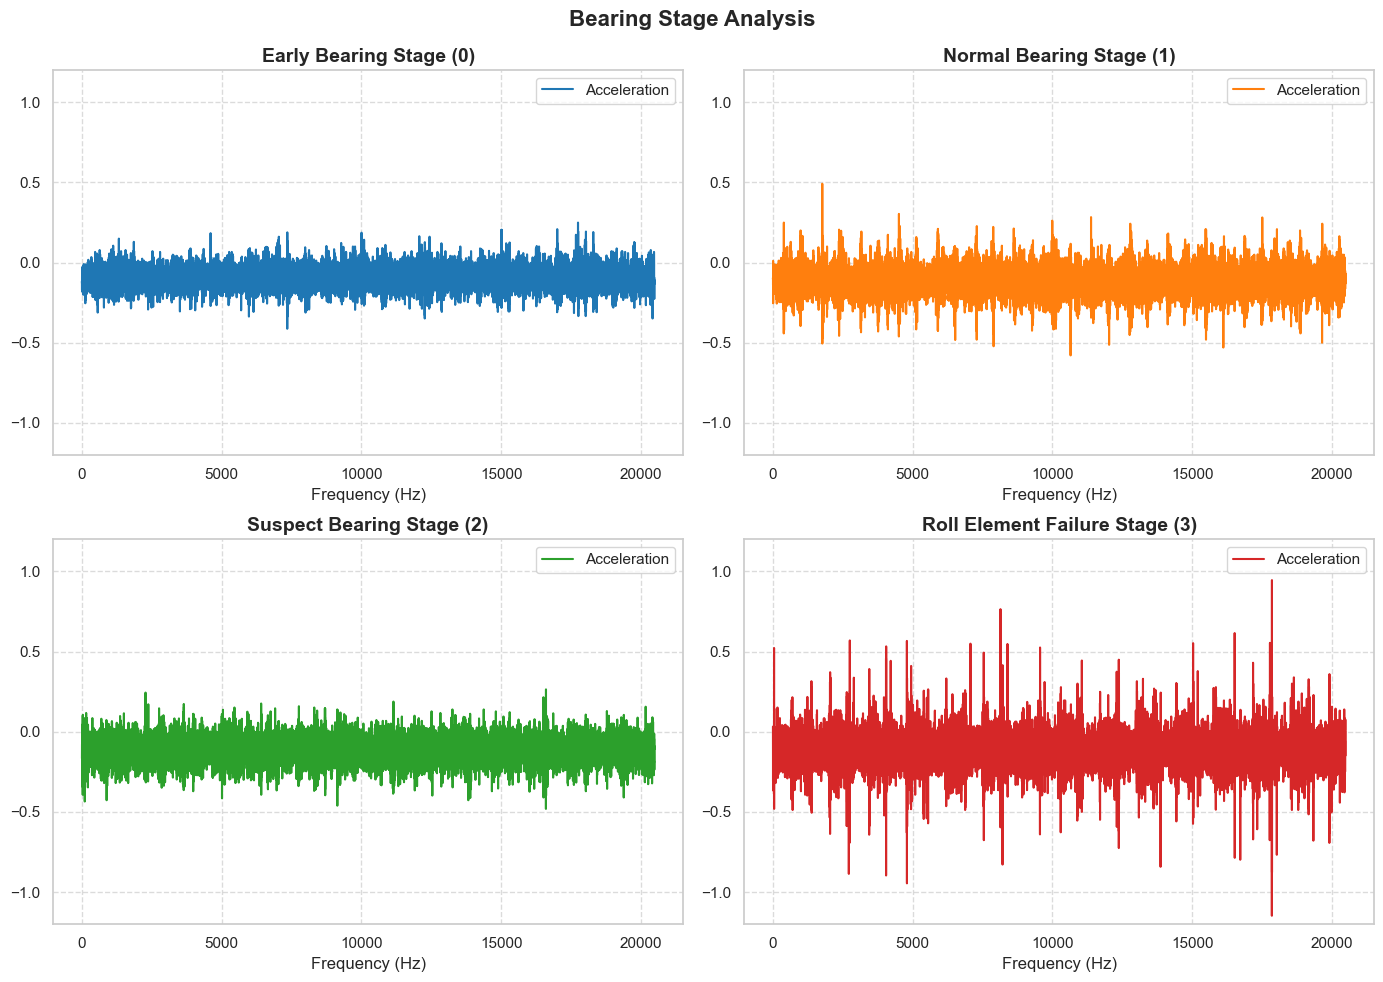

In [7]:
# import samples from different degredation stages 
df_0 = pd.read_csv('data/0.csv',sep=';') #stage 0
df_200 = pd.read_csv('data/200.csv',sep=';') # stage 1
df_900 = pd.read_csv('data/900.csv',sep=';') # stage 2
df_1300 = pd.read_csv('data/1300.csv',sep=';') # stage 3

# Set the style
sns.set(style="whitegrid")

# Create a figure and 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Define a common y-axis limit
y_limits = [-1.2, 1.2]

# Define titles and data
titles = [
    'Early Bearing Stage (0)',
    'Normal Bearing Stage (1)',
    'Suspect Bearing Stage (2)',
    'Roll Element Failure Stage (3)'
]
data_frames = [df_0, df_200, df_900, df_1300]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot each DataFrame on a different subplot
for ax, title, df, color in zip(axs.flatten(), titles, data_frames, colors):
    ax.plot(range(0, len(df)), df.b4x, color=color, linewidth=1.5, label='Acceleration')
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_ylim(y_limits)
    ax.set_xlabel("Frequency (Hz)", fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Adjust the layout
plt.tight_layout()

# Add a main title
fig.suptitle('Bearing Stage Analysis', fontsize=16, weight='bold')
plt.subplots_adjust(top=0.92)

# save figure to png
#plt.savefig('plot_ex_1a.png')

plt.show()

## 1b

### Create dataset with features.

In [24]:
# generate dataset with features:
data_path = 'data'
dataset = generate_dataset(data_path)

# Export to excel
dataset.to_excel('dataset_features.xlsx')

Processing files: 100%|██████████████████████████| 1724/1724 [03:29<00:00,  8.22it/s]


In [8]:
dataset.head(10)

,mean_x,mean_y,std_x,std_y,rms_x,rms_y,kurtosis_x,kurtosis_y,variance_x,variance_y,crest_factor_x,crest_factor_y,skewness_x,skewness_y,spectral_flatness_x,spectral_flatness_y,sample_entropy_x,sample_entropy_y,b4_state
index,,,,,,,,,,,,,,,,,,,
0,-0.090969,-0.094235,0.060086,0.066382,0.109020,0.115267,0.790250,1.807990,0.003610,0.004407,3.788279,4.086150,0.046609,0.008295,0.096071,0.145048,1.882153,1.963611,0
1,-0.091260,-0.087946,0.059421,0.064746,0.108900,0.109208,1.234703,1.873189,0.003531,0.004192,3.856767,5.741343,0.085164,-0.053792,0.091647,0.148553,2.017231,1.977537,0
2,-0.092597,-0.093106,0.059969,0.065255,0.110319,0.113696,0.924708,1.429695,0.003596,0.004258,3.589583,5.286029,0.009609,0.047138,0.089017,0.139277,2.033446,1.976102,0
3,-0.093485,-0.093244,0.059917,0.066303,0.111037,0.114413,0.652667,1.378184,0.003590,0.004396,3.539356,4.588643,-0.037259,0.021106,0.090138,0.140414,2.050200,1.988273,0
4,-0.104769,-0.093042,0.058607,0.065404,0.120046,0.113729,0.687223,1.128042,0.003435,0.004278,3.332048,3.780924,0.006678,-0.005512,0.075905,0.142373,2.027120,1.988056,0
5,-0.018549,-0.092251,0.063495,0.064713,0.066148,0.112684,0.614170,1.238299,0.004032,0.004188,5.019068,4.135444,-0.013040,-0.068305,0.250295,0.138438,1.910480,1.983077,0
6,-0.099928,-0.092892,0.058408,0.064928,0.115745,0.113333,0.868311,1.484047,0.003411,0.004216,3.438604,4.694145,0.023816,-0.014279,0.079909,0.138747,2.007273,1.982731,0
7,-0.056903,-0.092785,0.060297,0.064233,0.082907,0.112849,0.807403,1.515045,0.003636,0.004126,4.679950,4.475021,-0.081036,0.043939,0.157589,0.139677,1.874582,1.991523,0
8,-0.079501,-0.092462,0.059827,0.065976,0.099496,0.113587,0.957008,1.220830,0.003579,0.004353,3.980067,4.084984,-0.026472,0.029973,0.110134,0.143864,2.020190,1.968761,0


In [42]:
for i in range(0, 5):
    var = dataset[dataset.b4_state == i]['spectral_flatness_x'].mean()
    print(f'state: {i}: {var}')

state: 0: 0.10443083401477793
state: 1: 0.09431637719718174
state: 2: 0.09095162507877823
state: 3: 0.13833851373824396
state: 4: 0.16513563791150432


Kurtosis: Meet de 'tailedness' van de kans verdeling van het signaal, dat wil zeggen dat bij een hoge kurtosis in de data kan aangeven dat er grote schokken of grote afwijkingen zijn die mogelijk beschadigde bearings kan aangeven.

Skewness: Meet de assymmetrie van de kans verdeling van het signaal. Dus verandering in skewness kan een aanwijzing zijn dat er verschuiving in signaal gedrag plaats vind.

Spectral Flatness: Geeft aan hoe puur het signaal is, als deze waarde laag is wil dat zeggen de meeste amplitude van het signaal in een paar frequenties zit. En bij een hoge waarde heeft het signaal een meer uniform verdeelde amplitude over veel frequenties, veel ruis dus.

Crest factor: De crest factor is de grootste piek in het signaal gedeeld door de gemiddelde amplitude van het signaal. Als deze factor hoog is heeft het signaal hoge pieken.

Sample entropy: Geeft complexiteit en irregulariteit aan. Dus hoe onvoorspelbaar het signaal is. Bij een hoge waarde is er een minder herhaaldelijk signaal. Bij een lagere waarde is het een meer herhaadelijk signaal.

## 1c

### Correlatie matrix

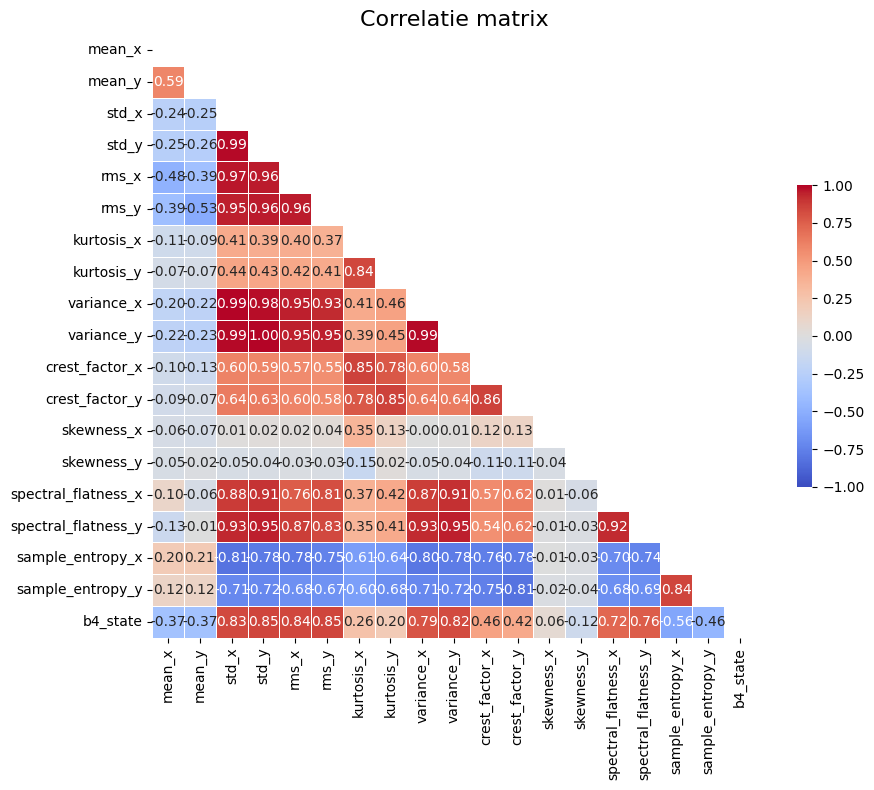

In [35]:
dataset = pd.read_excel('dataset_features.xlsx').drop(columns='index')
corr = dataset.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(10, 8))

heatmap = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, vmin=-1, vmax=1, ax=ax, cbar_kws={"shrink": .5})

plt.title("Correlatie matrix", fontsize=16)
plt.tight_layout()
plt.show()

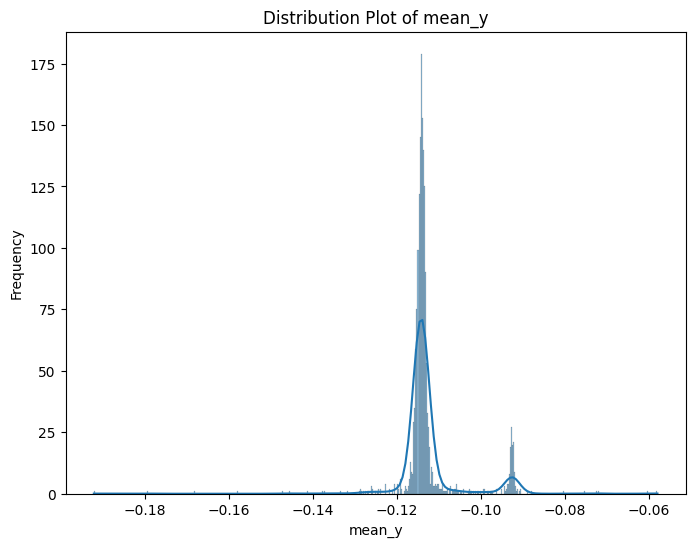

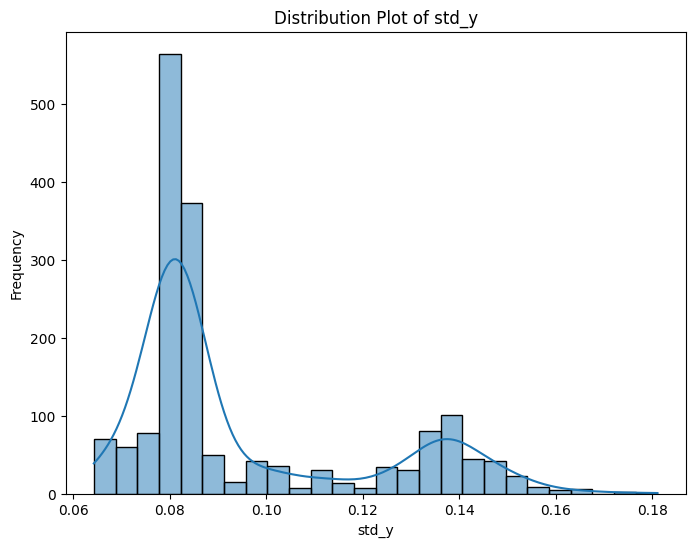

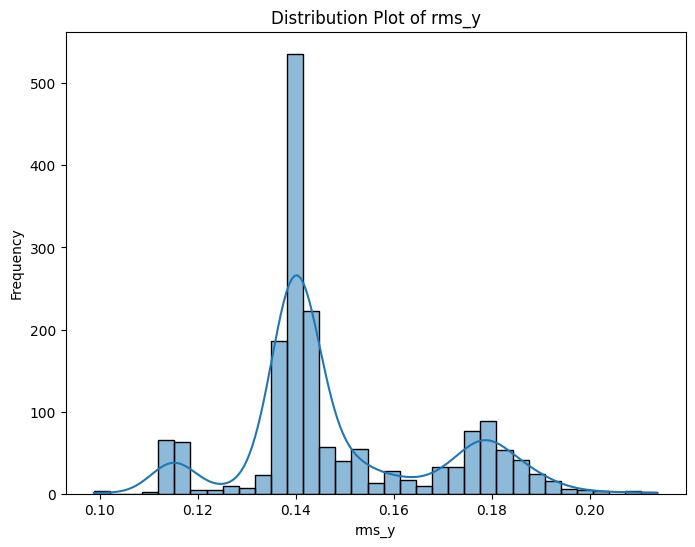

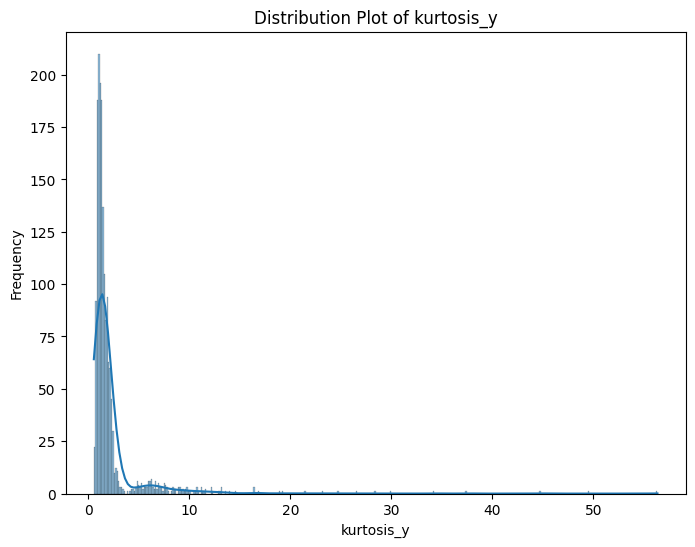

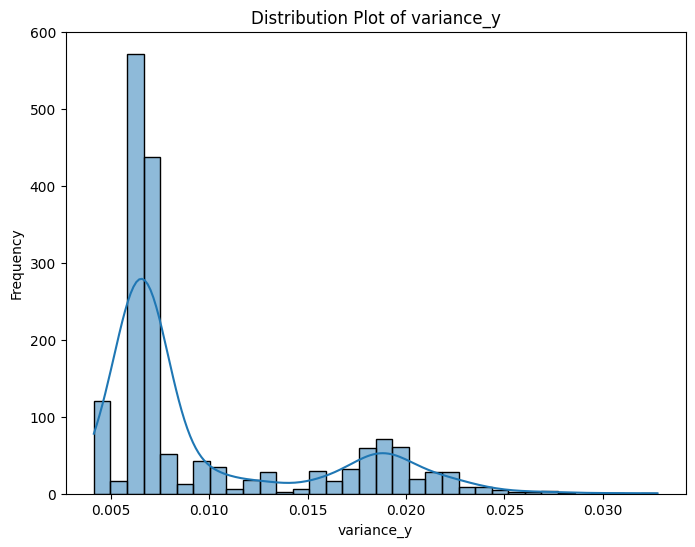

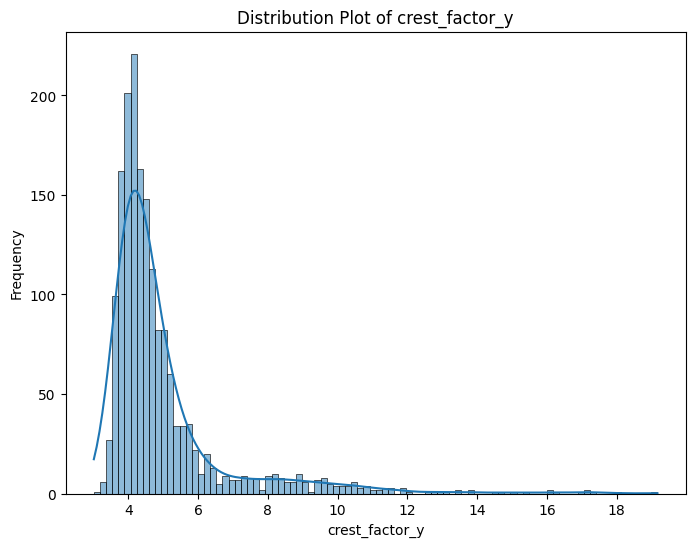

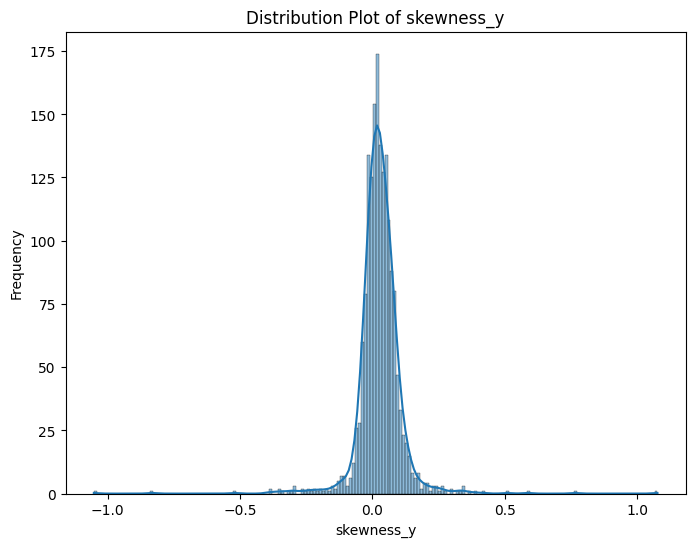

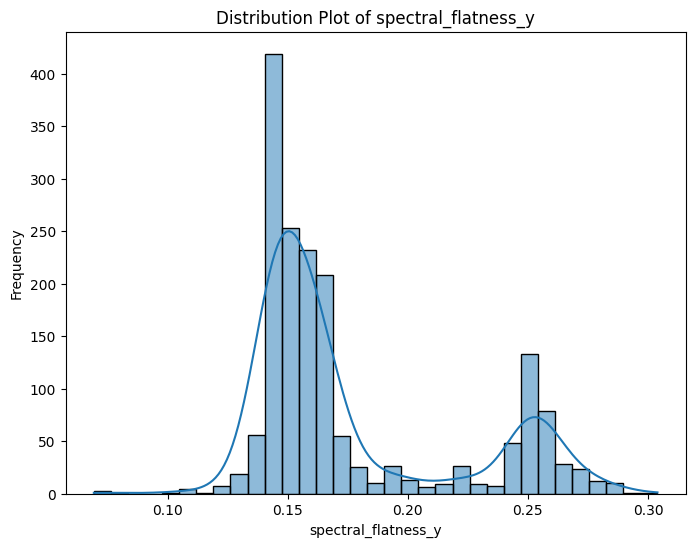

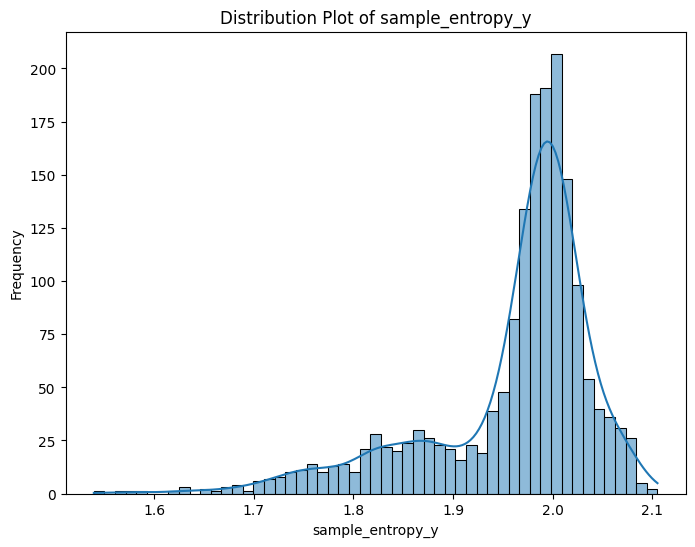

In [51]:
# Assuming 'dataset' is your DataFrame containing the columns mentioned
columns_with_y = ['mean_y', 'std_y', 'rms_y', 'kurtosis_y', 'variance_y', 'crest_factor_y', 'skewness_y', 'spectral_flatness_y', 'sample_entropy_y']

# Loop over each column and create a distribution plot
for column in columns_with_y:
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    sns.histplot(dataset[column], kde=True)
    plt.title(f'Distribution Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
